In [258]:
import os
import numpy as np
import pandas as pd

import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import os
from time import time, sleep
import ctypes
import sys
import skimage.io as skio
from scipy.signal import find_peaks
import skimage.exposure
from skimage.filters.rank import entropy
from skimage.measure import shannon_entropy
from scipy.signal import medfilt
from skimage.morphology import disk
import glob
import xgboost as xgb
from tifffile import imread, imwrite
import cv2
from joblib import Parallel, delayed
import seaborn as sns
from towbintools.foundation.image_handling import normalize_image
from towbintools.foundation.image_quality import normalized_variance_measure
from towbintools.foundation.zstack import normalize_zstack
from towbintools.foundation.file_handling import get_dir_filemap
from towbintools.foundation.utils import nan_helper

from sklearn.metrics import mean_squared_error, r2_score

In [259]:
def extract_features(img, features_size):
    img = normalize_image(img)
    std = np.std(img, axis =0)
    feature = np.zeros((1,features_size))
    feature[0, 0:std.shape[0]] = std
    return feature

def count_orientation_errors(orientation):
    # errors = np.count_nonzero(np.array(orientation) == [0, 0, 1])
    errors = 0
    for orient in orientation:
        if orient == [0, 0, 1]:
            errors += 1
    return errors

def extractPump_norm(straightened_image, clf):
    feature = extract_features(straightened_image, 5000)
    orientation_prediction = clf.predict_proba(feature).squeeze()
    # convert proba to one hot encoding
    pred_class = np.argmax(orientation_prediction)
    orientation = [0, 0, 0]
    orientation[pred_class] = 1
    
    std = np.std(straightened_image, axis =0)

    peaks, peak_dict = find_peaks(std, distance=20, prominence = 0.05, height = 0.1)


    if orientation == [1, 0, 0]:
        # plt.plot(straightIm[:, peaks[-1]])
        # plt.show()
        try:
            return -peak_dict['peak_heights'][-1], orientation
        except IndexError:
            return np.nan, orientation
    elif orientation == [0, 1, 0]:
        try:
            return -peak_dict['peak_heights'][0], orientation
        except IndexError:
            return np.nan, orientation
    else:
        return np.nan, orientation
    
    
def analyse_video(vid, model, **kwargs):
    min_std = kwargs.get('min_std', 0.008)
    std_coeff = kwargs.get('std_coeff', 0.75)
    distance = kwargs.get('distance', 4)
    wlen = kwargs.get('wlen', 10)

    print(f'min std: {min_std}')

    try:
        pump = []
        orientation = []

        clf = xgb.XGBClassifier()
        clf.load_model(model)
        
        for i in range(vid.shape[0]):
            pump_value, orient = extractPump_norm(vid[i, :, :], clf)
            pump.append(pump_value)
            orientation.append(orient)

        orientation_errors = count_orientation_errors(orientation)

        if orientation_errors/len(orientation) > 0.10:
            return np.nan

        pump = np.array(pump)

        pump = medfilt(pump)

        # plt.plot(pump)
        nans, x= nan_helper(pump)
        pump[nans]= np.interp(x(nans), x(~nans), pump[~nans])

        pump = medfilt(pump)
        
        std = np.std(pump)
        std = max(std, min_std)

        pump = medfilt(pump)
        # pump = medfilt(pump)
        # pump = medfilt(pump)
        
        peaks, _ = find_peaks(pump, distance=distance, prominence=std_coeff*std, wlen=wlen)

        # plt.plot(pump)
        # plt.plot(peaks, pump[peaks], "x")
        # plt.show()

        return len(peaks)
    except ValueError:
        return np.nan

def process_video(video_path, **kwargs):
    if video_path:
        vid = imread(video_path)
        mean_normalized_variance_of_vid = np.mean([normalized_variance_measure(frame) for frame in vid])
        if mean_normalized_variance_of_vid < 400:
            return np.nan
        normalized_vid = normalize_zstack(vid, each_plane = False, dest_dtype = np.float64) # type: ignore
        return analyse_video(normalized_vid, model=r"C:\Users\sacha\Documents\towbin_lab\pharynx\classify_orientation\model.json", **kwargs)
    else:
        return np.nan
    
def process_list_of_videos(video_paths, **kwargs):
    video_paths =  [path.replace('/mnt', '//izbkingston') for path in video_paths]
    return Parallel(n_jobs=12)(delayed(process_video)(video_path, **kwargs) for video_path in video_paths)

In [260]:
result_folder = "../pumping_count_results/"
result_files = [os.path.join(result_folder, f) for f in os.listdir(result_folder)]
# Load all manually annotated data

manual_files = [f for f in result_files if "manual" in f]
manual_data = pd.DataFrame()
for file in manual_files:
    data = pd.read_csv(file)
    data = data.dropna(subset=["ManualPumpCount"])
    data = data.loc[data['ManualPumpCount'] >= 0]
    manual_data = pd.concat([manual_data, data])

annotated_videos = manual_data["ImagePath"].unique()
print(manual_data.shape)

(127, 2)


In [261]:
auto_pump_count = process_list_of_videos(annotated_videos, min_std=0.008, std_coeff=0.55, distance=3, wlen=10)

In [262]:
# Remove manual data where auto pump count is nan

manual_data = manual_data.loc[~np.isnan(auto_pump_count)]
auto_pump_count = [x for x in auto_pump_count if np.isfinite(x)]

In [263]:
print(manual_data.shape)

(120, 2)


In [264]:
r2 = r2_score(manual_data["ManualPumpCount"], auto_pump_count)
rsme = mean_squared_error(manual_data["ManualPumpCount"], auto_pump_count, squared=False)
print('R2 score :', r2)
print('RSME :', rsme)

R2 score : 0.9512629634302738
RSME : 2.3219962675824153


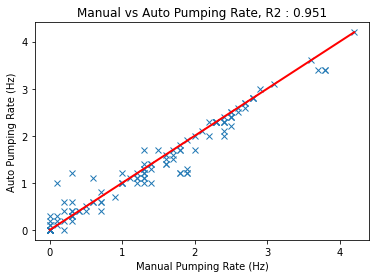

In [265]:
plt.plot(manual_data["ManualPumpCount"]/10, np.array(auto_pump_count)/10, "x")
plt.plot([0, np.max(manual_data["ManualPumpCount"]/10)], [0, np.max(manual_data["ManualPumpCount"]/10)], linewidth=2, color='r')
plt.xlabel("Manual Pumping Rate (Hz)")
plt.ylabel("Auto Pumping Rate (Hz)")
plt.title(f"Manual vs Auto Pumping Rate, R2 : {r2.round(3)}")
plt.show()